<a href="https://colab.research.google.com/github/randywreed/gpt2_lda/blob/master/Classify_gpt2_as_religion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup (always run this)


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## MODIFY THE FOLLOWING CELLS: 
You must have already created a folder in your google drive for use<br>
The next two cells give colab permission to use your google drive (you will do this twice)<br>
In the following cell change the *paulaidir* to google drive directory to store models and data<br>
change *trans* to the tranlation (should correspond to the .csv file name)

In [2]:
from google.colab import drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import gspread
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [1]:
#set paulaidir to you google drive directory
#trans should be equivalent to the .csv file for the full translation (i.e. niv.csv)
#if you need to see a list of csv files continue down, and then come back, change and re-run this cell
paulaidir='/content/drive/My Drive/AI & Tech Research/Religion of GPT2/'
trans="wikipedia_relwcat - wikipedia_relwcat"
myemail="reedrw@appstate.edu"

In [2]:
from pathlib import Path
paulpath=Path(paulaidir)
print(paulpath)
path=Path(paulaidir+'fastai/')

/content/drive/My Drive/AI & Tech Research/Religion of GPT2


In [ ]:
#to see a list of .csv files remove the # from the following lines of the cell
import glob
for filename in glob.glob(str(paulpath)+"/*.csv"):
  print(filename)



/content/drive/My Drive/AI & Tech Research/Religion of GPT2/DedooseCodesExport_2020_3_25_1533.csv
/content/drive/My Drive/AI & Tech Research/Religion of GPT2/newults.csv
/content/drive/My Drive/AI & Tech Research/Religion of GPT2/T4Results.csv
/content/drive/My Drive/AI & Tech Research/Religion of GPT2/wiki.csv
/content/drive/My Drive/AI & Tech Research/Religion of GPT2/wikip_00.csv
/content/drive/My Drive/AI & Tech Research/Religion of GPT2/wikip_01.csv
/content/drive/My Drive/AI & Tech Research/Religion of GPT2/wikip_03.csv
/content/drive/My Drive/AI & Tech Research/Religion of GPT2/wikip_06.csv
/content/drive/My Drive/AI & Tech Research/Religion of GPT2/wikip_04.csv
/content/drive/My Drive/AI & Tech Research/Religion of GPT2/wikip_05.csv
/content/drive/My Drive/AI & Tech Research/Religion of GPT2/wikip_07.csv
/content/drive/My Drive/AI & Tech Research/Religion of GPT2/wikip_08.csv
/content/drive/My Drive/AI & Tech Research/Religion of GPT2/wikip_09.csv
/content/drive/My Drive/AI & T

In [ ]:
translation=trans+".csv"  
file=paulaidir+translation
file

'/content/drive/My Drive/AI & Tech Research/Religion of GPT2/wikipedia_relwcat - wikipedia_relwcat.csv'

In [ ]:
!pip install --upgrade -q gspread


In [ ]:
pip install PyOpenSSL

     |████████████████████████████████| 61kB 4.5MB/s 
     |████████████████████████████████| 2.7MB 14.5MB/s 


In [3]:
def getloggerdt():
  import pytz
  from datetime import datetime
  now = datetime.now(pytz.timezone('America/New_York'))
  
  log_ent=now.strftime("%m/%d/%Y, %H:%M:%S")
  return log_ent


In [7]:
logfilename=trans+"_log"
print(logfilename)

try:
  logwriter=gc.open(logfilename).sheet1
except Exception:
  logsh=gc.create(logfilename)
  logsh.share(myemail,perm_type='user',role='writer')
  logwriter=logsh.get_worksheet(0)

logwriter.append_row([getloggerdt(),'start log'])

wikipedia_relwcat - wikipedia_relwcat_log


{'spreadsheetId': '1RyYJaX1ysSAo4JpXhbRVcrRm1UGV3oUI7SGLg1rwzUs',
 'tableRange': 'Sheet1!A1:B9',
 'updates': {'spreadsheetId': '1RyYJaX1ysSAo4JpXhbRVcrRm1UGV3oUI7SGLg1rwzUs',
  'updatedCells': 2,
  'updatedColumns': 2,
  'updatedRange': 'Sheet1!A10:B10',
  'updatedRows': 1}}

In [ ]:
#run this if fixing an UNAUTHENTICATED error for the spreadsheet
try:
  worksheet = gc.open("PaulAI_Experiments_"+trans).sheet1
except Exception:
  spreadsh=gc.create("PaulAI_Experiments_"+trans)
  spreadsh.share(myemail,perm_type='user',role='writer')
  worksheet=spreadsh.get_worksheet(0)


In [ ]:
!pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu102/torch_nightly.html
import torch

Looking in links: https://download.pytorch.org/whl/nightly/cu102/torch_nightly.html


In [22]:
from fastai.distributed import *
import argparse

In [23]:
from fastai import *
from fastai.text import *

In [24]:
from fastai.callbacks import SaveModelCallback

In [11]:
# import fastai.utils.collect_env

# fastai.utils.collect_env.show_install()

In [12]:
Config.DEFAULT_CONFIG={
    'data_path': paulaidir+'fastai/data',
    'model_path': paulaidir+'fastai/model'
}
Config.create(paulaidir+'fastai/myconfig.yml')
Config.DEFAULT_CONFIG_PATH=paulaidir+'fastai/myconfig.yml'

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [4]:
# bs=48
# bs=24
bs=96

In [5]:
#distributed Processing setup
#parser = argparse.ArgumentParser()
#parser.add_argument("--local_rank", type=int)
#args = parser.parse_args()
#torch.cuda.set_device(args.local_rank)
#torch.distributed.init_process_group(backend='nccl', init_method='env://')
bs


96

In [7]:
import torch
torch.cuda.set_device(0)

In [ ]:
logwriter.append_row([getloggerdt(),'setup complete'])

{'spreadsheetId': '1RyYJaX1ysSAo4JpXhbRVcrRm1UGV3oUI7SGLg1rwzUs',
 'tableRange': 'Sheet1!A1:B4',
 'updates': {'spreadsheetId': '1RyYJaX1ysSAo4JpXhbRVcrRm1UGV3oUI7SGLg1rwzUs',
  'updatedCells': 2,
  'updatedColumns': 2,
  'updatedRange': 'Sheet1!A5:B5',
  'updatedRows': 1}}

### Language model (Always Run)


Now let's grab the full dataset for what follows.

In [ ]:
file

'/content/drive/My Drive/AI & Tech Research/Religion of GPT2/wikipedia_relwcat - wikipedia_relwcat.csv'

In [9]:
import pandas as pd

In [10]:
relfile=Path('/content/drive/My Drive/AI & Tech Research/Religion of GPT2/fastai/data/wikipedia_relwcat - wikipedia_relwcat.csv')
secfile=Path('/content/drive/My Drive/AI & Tech Research/Religion of GPT2/fastai/data/wiki_secular.csv')

In [11]:
print(relfile)

/content/drive/My Drive/AI & Tech Research/Religion of GPT2/fastai/data/wikipedia_relwcat - wikipedia_relwcat.csv


In [12]:
#read csvs into pandaas dataframe
rel=pd.read_csv(relfile)
sec=pd.read_csv(secfile)



In [13]:
print (rel.columns)
print(sec.columns)

Index(['Topic', 'Text', 'Flag'], dtype='object')
Index(['title', 'text', 'rel'], dtype='object')


In [14]:
sec.columns=['Topic','Text','Flag']


In [15]:
#set secular to S, religious to r
rel.Flag='R'
sec.Flag='S'

In [16]:
#merge two files
df=pd.concat([rel,sec])

In [17]:
#fills any blank article with just the topic to allow processing, but need to fix this
df.Text.fillna(df.Topic,inplace=True)

In [18]:
#check text for na's
df[df['Text'].isna()]

,Topic,Text,Flag


#### Creating the TextLMDataBunch (if run once, skip to loading saved data)

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [25]:
data_lm=TextLMDataBunch.from_df(path, train_df=df, valid_df=df, text_cols="Text",bs=bs)

In [ ]:
data_lm.show_batch()

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:134: UserWarning: 
    Found GPU0 Tesla T4 which requires CUDA_VERSION >= 10000 to
     work properly, but your PyTorch was compiled
     with CUDA_VERSION 9000. Please install the correct PyTorch binary
     using instructions from https://pytorch.org
    
  warnings.warn(incorrect_binary_warn % (d, name, 10000, CUDA_VERSION))


idx,text
0,"to it . \n xxmaj if you click on "" xxmaj related changes "" at the side of this page , you will see a list of the most recent changes in articles to which this page links . xxmaj this page links to itself and its talk page so that changes to them can be tracked by the same means . \n \n \n = = xxunk"
1,"( xxmaj greek "" baptize "" ) , they do not eat "" , and "" baptize "" where xxunk , the new xxmaj christian rite , is intended . xxmaj the older ritual washing use of xxunk is relevant in the context of funerals since any xxmaj jew coming into contact with the dead body must undertake ritual washing . xxmaj during the xxmaj second xxmaj temple and early"
2,"functional xxmaj christology "" analyzes the works of xxmaj jesus xxmaj christ , while "" soteriological xxmaj christology "" analyzes the "" salvific "" xxunk of xxmaj christology . xxmaj several approaches can be distinguished within xxmaj christology . xxmaj the term "" xxmaj christology from above "" or "" high xxmaj christology "" refers to approaches that include aspects of divinity , such as xxmaj lord and xxmaj son"
3,"other than the creator will cease to exist , except xxmaj osiris , who will survive along with him . xxmaj details about this eschatological prospect are left unclear , including the fate of the dead who are associated with xxmaj osiris . xxmaj yet with the creator god and the god of renewal together in the waters that gave rise to the orderly world , there is the potential"
4,"xxmaj xxunk xxunk states , "" xxmaj just as these ancient martyrs were revealed once more , xxmaj catholics were beginning to be martyred afresh , both in mission fields overseas and in the struggle to win back xxmaj protestant northern xxmaj europe : the catacombs proved to be an inspiration for many to action and to heroism . xxunk missions were carried to new places beginning with the new"


In [19]:
print (paulpath)
print(path)

/content/drive/My Drive/AI & Tech Research/Religion of GPT2
/content/drive/My Drive/AI & Tech Research/Religion of GPT2/fastai


Let's save our databunch for next time:

In [20]:
data_lm.path=path
print (data_lm.path)

data_lm.save('lm_databunch_'+trans)
#logwriter.append_row([getloggerdt(),'databunch saved as lm_databuch_'+trans])


NameError: ignored

### Loading saved data, and creating the language model

In the future we can load the data:

In [25]:
data_lm = load_data(path, 'lm_databunch_'+trans, bs=bs)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [26]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
#logwriter.append_row([getloggerdt(),'learner created'])


In [27]:
Config.DEFAULT_CONFIG


{'data_archive_path': '/root/.fastai/data',
 'data_path': '/root/.fastai/data',
 'model_path': '/root/.fastai/models'}

In [ ]:
wiki_itos = pickle.load(open(Config().model_path()/'wt103-fwd/itos_wt103.pkl', 'rb'))

### vocabulary Tests (can skip)

In [ ]:
wiki_itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [ ]:
vocab = data_lm.vocab

In [ ]:
vocab.stoi["eloi"]

9496

In [ ]:
vocab.itos[vocab.stoi["eloi"]]

'eloi'

In [ ]:
"eloi" in wiki_itos

False

In [ ]:
vocab.itos[vocab.stoi["mobula"]]

'xxunk'

In [ ]:
awd = learn_lm.model[0]

### Difference in vocabulary between Bible translation and Wikipedia (can skip)

We are going to load wiki_itos, which can be downloaded along with wikitext-103.  We will compare the vocabulary from wikitext with the vocabulary in Bible translation.  It is to be expected that the two sets have some different vocabulary words, and that is no problem for transfer learning!

In [ ]:
from scipy.spatial.distance import cosine as dist

In [ ]:
enc = learn_lm.model[0].encoder

In [ ]:
enc.weight.size()

torch.Size([9776, 400])

In [ ]:
len(wiki_itos)

60000

In [ ]:
len(vocab.itos)

9776

In [ ]:
i, unks = 0, []
while len(unks) < 50:
    if data_lm.vocab.itos[i] not in wiki_itos: unks.append((i,data_lm.vocab.itos[i]))
    i += 1

In [ ]:
wiki_words = set(wiki_itos)

In [ ]:
bible_words = set(vocab.itos)

In [ ]:
wiki_not_bible = wiki_words.difference(bible_words)

In [ ]:
bible_not_wiki = bible_words.difference(wiki_words)

In [ ]:
wiki_not_bible_list = []

for i in range(100):
    word = wiki_not_bible.pop()
    wiki_not_bible_list.append(word)
    wiki_not_bible.add(word)

In [ ]:
wiki_not_bible_list[:15]

['oases',
 'approving',
 'tuck',
 'aphid',
 'haines',
 'sōryū',
 'pasties',
 '1101',
 'hønefoss',
 '402',
 'unwritten',
 'svetlana',
 'ipo',
 'fimi',
 '31.2']

In [ ]:
bible_not_wiki_list = []

for i in range(100):
    word = bible_not_wiki.pop()
    bible_not_wiki_list.append(word)
    bible_not_wiki.add(word)

In [ ]:
bible_not_wiki_list[:15]

['ibleam',
 'galatia',
 'jehoiarib',
 'hachilah',
 'elpaal',
 'epaphras',
 'iddo',
 'buzite',
 'grope',
 'tubal',
 'zanoah',
 'arvad',
 'hasupha',
 'blasphemies',
 'premeditation']

All words that appear in the IMDB vocab, but not the wikitext-103 vocab, will be initialized to the same random vector in a model.  As the model trains, we will learn these weights.

In [ ]:
#test words
unique_wiki_words="modernisation"
common_word="house"
unique_bible_word1="blasphemies"
unique_bible_words2="displeasing"

In [ ]:
vocab.stoi[unique_wiki_words]

0

In [ ]:
unique_wiki_words in wiki_words

True

In [ ]:
vocab.stoi[unique_bible_word1]

5193

In [ ]:
unique_bible_word1 in wiki_words, unique_bible_word1 in bible_words

(False, True)

In [ ]:
vocab.stoi[unique_bible_words2]

4559

In [ ]:
unique_bible_words2 in wiki_words, unique_bible_words2 in bible_words

(False, True)

In [ ]:
common_word in wiki_words, common_word in bible_words

(True, True)

In [ ]:
np.allclose(enc.weight[vocab.stoi[unique_bible_word1], :], 
            enc.weight[vocab.stoi[unique_bible_words2], :])

True

In [ ]:
np.allclose(enc.weight[vocab.stoi[unique_bible_word1], :], 
            enc.weight[vocab.stoi[common_word], :])

False

In [ ]:
new_word_vec = enc.weight[vocab.stoi[unique_bible_word1], :]

### Generating fake Bible texts (using wiki-text model) (can skip)

In [ ]:
TEXT = "The color of the sky is"
N_WORDS = 40
N_SENTENCES = 2

In [ ]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The color of the sky is not used in any of the Star Wars , and it is often explained that the Star Wars Star Wars - inspired Star Wars Dark Shadows War and
The color of the sky is displayed in the main character and the character is entirely blue in color . The character appears as a red figure in the two - part character The Boat Race . The character first appears


In [ ]:
TEXT = "And Jesus said"
N_WORDS = 30
N_SENTENCES = 2

In [ ]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

And Jesus said they would not love Jesus Christ because they would never love Jesus . Jesus will come to a cure with Jesus Christ and
And Jesus said they were not God and Jesus Christ , Jesus Christ the Jesus Christ , Jesus Christ Christ , and


In [ ]:
TEXT = "I, Paul, an apostle"
N_WORDS = 30
N_SENTENCES = 2

In [ ]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I, Paul, an apostle and a Christian Christian , was part of the Congregation for the Religion of Jesus Christ of Latter - day Saints (
I, Paul, an apostle of the Christian faith , and a Christian , published a book on religious faith and religion in Christian literature , called The Christian in


In [ ]:
TEXT = "And Jesus, moved with compassion,"
N_WORDS = 40
N_SENTENCES = 2

In [ ]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

And Jesus, moved with compassion, first appeared on Late Night with Paul Hunter , on May 29 , March 20 , May 29 , May 20 , March 18 , May her final day of
And Jesus, moved with compassion, was released on US - United Nations Special Protection Agency , and continues to be an important source of evidence that Jesus Christ was accused of supporting the Roman Emperor


Lowering `temperature` will make the texts less randomized.

In [ ]:
#doc(LanguageLearner.predict)

In [ ]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.10) for _ in range(N_SENTENCES)))

And Jesus, moved with compassion, and Jesus Christ , Jesus Christ , Jesus Christ , Jesus Christ , Jesus Christ , Jesus Christ , Jesus Christ , Jesus Christ
And Jesus, moved with compassion, and Jesus Christ , Jesus Christ , Jesus Christ , Jesus Christ , Jesus Christ , Jesus Christ , Jesus Christ , Jesus Christ


### Training the language model (run first time - otherwise go to load saved weights)

Now, we want to choose a good learning rate.

In [ ]:
learn_lm.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


{'spreadsheetId': '1RyYJaX1ysSAo4JpXhbRVcrRm1UGV3oUI7SGLg1rwzUs',
 'tableRange': 'Sheet1!A1:B5',
 'updates': {'spreadsheetId': '1RyYJaX1ysSAo4JpXhbRVcrRm1UGV3oUI7SGLg1rwzUs',
  'updatedCells': 2,
  'updatedColumns': 2,
  'updatedRange': 'Sheet1!A6:B6',
  'updatedRows': 1}}

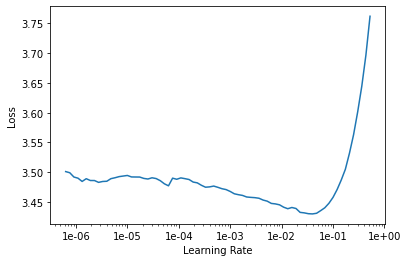

In [ ]:
learn_lm.recorder.plot(skip_end=15)
logwriter.append_row([getloggerdt(),'learning rate created'])


You want to choose a learning rate that is in the middle of slope BEFORE it increases again.

In [ ]:
#set the learning rate from above here
lr = 1e-2
lr *= bs/48
logwriter.append_row([getloggerdt(),'learning rate set to '+str(lr)])


{'spreadsheetId': '1RyYJaX1ysSAo4JpXhbRVcrRm1UGV3oUI7SGLg1rwzUs',
 'tableRange': 'Sheet1!A1:B6',
 'updates': {'spreadsheetId': '1RyYJaX1ysSAo4JpXhbRVcrRm1UGV3oUI7SGLg1rwzUs',
  'updatedCells': 2,
  'updatedColumns': 2,
  'updatedRange': 'Sheet1!A7:B7',
  'updatedRows': 1}}

In [ ]:
learn_lm.to_fp16();

In [ ]:
#This trains the top layer of the language model once
learn_lm.fit_one_cycle(1, lr*10, moms=(0.8,0.7),callbacks=[SaveModelCallback(learn_lm, every='epoch',monitor='accuracy', name='saved_net'+trans)])
logwriter.append_row([getloggerdt(),'top layer of model trained'])


epoch,train_loss,valid_loss,accuracy,time
0,4.672422,4.428312,0.303565,52:37


{'spreadsheetId': '1RyYJaX1ysSAo4JpXhbRVcrRm1UGV3oUI7SGLg1rwzUs',
 'tableRange': 'Sheet1!A1:B7',
 'updates': {'spreadsheetId': '1RyYJaX1ysSAo4JpXhbRVcrRm1UGV3oUI7SGLg1rwzUs',
  'updatedCells': 2,
  'updatedColumns': 2,
  'updatedRange': 'Sheet1!A8:B8',
  'updatedRows': 1}}

Since this is relatively slow to train, we will save our weights:

In [ ]:
learn_lm.save('fit_1'+trans)
logwriter.append_row([getloggerdt(),'top layer of model saved as fit_1'+trans])


{'spreadsheetId': '1RyYJaX1ysSAo4JpXhbRVcrRm1UGV3oUI7SGLg1rwzUs',
 'tableRange': 'Sheet1!A1:B8',
 'updates': {'spreadsheetId': '1RyYJaX1ysSAo4JpXhbRVcrRm1UGV3oUI7SGLg1rwzUs',
  'updatedCells': 2,
  'updatedColumns': 2,
  'updatedRange': 'Sheet1!A9:B9',
  'updatedRows': 1}}

In [30]:
learn_lm.path

PosixPath('/content/drive/My Drive/AI & Tech Research/Religion of GPT2')

In [28]:
learn_lm.path=Path("/content/drive/My Drive/AI & Tech Research/Religion of GPT2/fastai/")
print(learn_lm.path)
print(trans)

/content/drive/My Drive/AI & Tech Research/Religion of GPT2/fastai
wikipedia_relwcat - wikipedia_relwcat


In [29]:
learn_lm.load('fit_1'+trans);

In [30]:
#set this learning rate to the same thing (you can play with it if you want)
lr = 1e-3
lr *= bs/48

To complete the fine-tuning, we can then unfreeze and launch a new training.<br> This will train the entire model 10 times. It will save the model each time just in case the system crashes.

In [31]:
learn_lm.unfreeze()

In [ ]:
learn_lm.fit_one_cycle(10, lr, moms=(0.8,0.7),callbacks=[SaveModelCallback(learn_lm, every='epoch',monitor='accuracy', name='10saved_net'+trans)])

epoch,train_loss,valid_loss,accuracy,time
0,3.756750,3.679063,0.372557,58:46
1,3.680443,3.553093,0.381767,58:53
2,3.509700,3.469995,0.387234,58:51
3,3.454278,3.370074,0.395507,58:52


In [34]:
!nvidia-smi

Fri Jun 26 17:37:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    26W /  75W |   6455MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [32]:
#restart if interrupted
restart_ep=4
learn_lm.fit_one_cycle(10,lr, moms=(0.8,0.7), start_epoch=restart_ep, callbacks=[SaveModelCallback(learn_lm, every='epoch',monitor='accuracy', name='10saved_net'+trans)])

Loaded 10saved_netwikipedia_relwcat - wikipedia_relwcat_3


epoch,train_loss,valid_loss,accuracy,time


RuntimeError: ignored

In [ ]:
learn_lm.save('fine_tuned_'+trans)
logwriter.append_row([loggerdt(),'fine tuned model save as fine_tuned_'+trans])


We have to save not just the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn_lm.save_encoder('fine_tuned_enc_'+trans)
logwriter.append_row([getloggerdt,'fine_tuned encoder saved as fine_tuned_enc_'+trans])


### Loading our saved weights (must run)

In [ ]:
learn_lm.load('fine_tuned_'+trans);
learn_lm.path

PosixPath('/content/drive/My Drive/testai')

#### Encoder Example (Can Skip)###

Now that we've trained our model, different representations have been learned for the words that were in IMDB but not wiki (remember that at the beginning we had initialized them all to the same thing):

In [ ]:
enc = learn_lm.model[0].encoder

In [ ]:
np.allclose(enc.weight[vocab.stoi[unique_bible_word1], :], 
            enc.weight[vocab.stoi[unique_bible_words2], :])

NameError: ignored

In [ ]:
np.allclose(enc.weight[vocab.stoi[unique_bible_word1], :], new_word_vec)

NameError: ignored

#### More generated Bible passages (can skip)

How good is our model? Well let's try to see what it predicts after a few given words.

In [ ]:
TEXT = "and Jesus said"
N_WORDS = 40
N_SENTENCES = 2

In [ ]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

and Jesus said to him , “ i am He . ” And Jesus * said to him , “ Follow Me . ” xxbos Now the word of the Lord came to me saying ,
and Jesus said to them , “ You are ruby , or who are you , but they must walk in the darkness ? You have no regard for those who hate Me . xxbos For indeed in this


In [ ]:
TEXT = "I, Paul, an apostle"
N_WORDS = 30
N_SENTENCES = 2

In [ ]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I, Paul, an apostle of Christ Jesus by the will of God , the Lord God of hosts , who is Christ , the church and the faith
I, Paul, an apostle of Christ Jesus by the will of God , who is called by Christ Jesus Christ ; xxbos He said , “


In [ ]:
TEXT = "And Jesus, moved with compassion,"
N_WORDS = 40
N_SENTENCES = 2

In [ ]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

And Jesus, moved with compassion, * said to them , “ Why do you still believe ? ” xxbos Into the first of all your fruits you shall shall give it to the priest , for it is a holy thing to the
And Jesus, moved with compassion, * said to them , “ Keep watch with the chief priests and bind them to keep My charge . xxbos Beside the border of Naphtali , from the east side to the west side ,


### Classifier Setup (Run first time)

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [ ]:
logwriter.append_row([getloggerdt(),'starting classifier setup'])


In [ ]:
bs=48

In [ ]:
#create test set from pandas
df_copy=df.copy()
print('The number of verses in the whole translation, columns=',df_copy.shape)

The number of verses in the whole translation, columns= (31103, 7)


In [ ]:
#Leave out the stuff that we'll test on (we set classifier to blank)
is_testable=df_copy['classifier']!=''
df_testable=df_copy[is_testable]
print('the number of verses that we will train on, colums=',df_testable.shape)

the number of verses that we will train on, colums= (30261, 7)


In [ ]:
df_testable.groupby('classifier').agg('count')

,Version_Full_Name,Version_Abbreviation,Book,Chapter,Verse_Number,Verse_Text
classifier,,,,,,
Non-Paul,28767,28767,28767,28767,28767,28767
Paul,1494,1494,1494,1494,1494,1494


In [ ]:
df_copy.groupby('classifier').agg('count')

,Version_Full_Name,Version_Abbreviation,Book,Chapter,Verse_Number,Verse_Text
classifier,,,,,,
,842,842,842,842,842,842
Non-Paul,28767,28767,28767,28767,28767,28767
Paul,1494,1494,1494,1494,1494,1494


In [ ]:
#Create a training set from the Paul material
df_sel_paul=df_copy.loc[df_copy['classifier'] == 'Paul']
df_sel_paul.head()
df_sample_paul=df_sel_paul.sample(frac=0.80, random_state=0)

In [ ]:
print('the verses in the Pauline training set (80%)=',df_sample_paul.shape)

the verses in the Pauline training set (80%)= (1195, 7)


In [ ]:
#create a training set from the nonPaul material
df_sel_nonpaul=df_copy.loc[df_copy['classifier']=='Non-Paul']
df_sample_nonpaul=df_sel_nonpaul.sample(frac=0.80, random_state=0)
print('the verses in the non-Pauline training set (80%)=',df_sample_nonpaul.shape)

the verses in the non-Pauline training set (80%)= (23014, 7)


In [ ]:
#append Paul training and nonPaul training sets
df_train=pd.concat([df_sample_paul,df_sample_nonpaul])
print('combined training sets (Pauline/non-pauline)=',df_train.shape)

combined training sets (Pauline/non-pauline)= (24209, 7)


In [ ]:
# get usued record from paul set for test set
paul_test=df_sel_paul.drop(df_sample_paul.index)
print('the testing set for Pauline material=',paul_test.shape)

the testing set for Pauline material= (299, 7)


In [ ]:
#get unused records for test set
nonpaul_test=df_sel_nonpaul.drop(df_sample_nonpaul.index)
print('the testing set for Non-Pauline material=',nonpaul_test.shape)

the testing set for Non-Pauline material= (5753, 7)


In [ ]:
#append paul and nonpaul test sets
df_test=pd.concat([paul_test,nonpaul_test])
print('combined testing sets=',df_test.shape)

combined testing sets= (6052, 7)


In [ ]:
df_test.groupby(['classifier']).head(3)

,Version_Full_Name,Version_Abbreviation,Book,Chapter,Verse_Number,Verse_Text,classifier
27942,New American Standard Bible,NASB,Romans,1,12,"that is, that I may be encouraged together wit...",Paul
27954,New American Standard Bible,NASB,Romans,1,24,Therefore God gave them over in the lusts of t...,Paul
27955,New American Standard Bible,NASB,Romans,1,25,"For they exchanged the truth of God for a lie,...",Paul
10,New American Standard Bible,NASB,Genesis,1,11,"Then God said, “Let the earth sprout vegetatio...",Non-Paul
13,New American Standard Bible,NASB,Genesis,1,14,"Then God said, “Let there be lights in the exp...",Non-Paul
19,New American Standard Bible,NASB,Genesis,1,20,"Then God said, “Let the waters teem with swarm...",Non-Paul


In [ ]:
#create the classifier data loader using the test and training sets
data_clas=TextClasDataBunch.from_df(path, train_df=df_train, valid_df=df_test, text_cols='Verse_Text', 
                                    label_cols='classifier',vocab=data_lm.vocab, bs=bs, num_workers=1)

In [ ]:
#data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path#
#             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
#             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
#             .databunch(bs=bs, num_workers=1))

In [ ]:
data_clas.path=paulpath

In [ ]:
#save the classifier data loader
class_name='bible_textlist_class_'+trans
data_clas.save(class_name)
data_clas.path
logwriter.append_row([getloggerdt(),'classifier data loader created as bible_textlist_class_'+trans])


PosixPath('/content/drive/My Drive/testai')

### Load Classifier (must run)

In [ ]:
#Load the classifier data loader
logwriter.append_row([getloggerdt(),'starting classifier loading'])

data_clas = load_data(paulpath,'bible_textlist_class_'+trans, bs=bs, num_workers=1)

In [ ]:
#create a learner for the classifere, add  the data loader to the pre-trained model
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3) #.to_fp16()
learn_c.path=paulpath
learn_c.load_encoder('fine_tuned_enc'+trans)
logwriter.append_row([getloggerdt(),'classifier learner created as learn_c'])



RNNLearner(data=TextClasDataBunch;

Train: LabelList (24209 items)
x: TextList
xxbos xxmaj now if xxmaj christ is preached , that xxmaj he has been raised from the dead , how do some among you say that there is no resurrection of the dead ?,xxbos xxmaj you are looking at things as they are outwardly . xxmaj if anyone is confident in himself that he is xxmaj christ ’s , let him consider this again within himself , that just as he is xxmaj christ ’s , so also are we .,xxbos xxmaj for if we believe that xxmaj jesus died and rose again , even so xxmaj god will bring with xxmaj him those who have fallen asleep in xxmaj jesus .,xxbos xxmaj you who boast in the xxmaj law , through your breaking the xxmaj law , do you dishonor xxmaj god ?,xxbos xxmaj after that xxmaj he appeared to more than five hundred brethren at one time , most of whom remain until now , but some have fallen asleep ;
y: CategoryList
Paul,Paul,Paul,Paul,Paul
Path: /content/drive/My Drive/testai/DigitialJesus/Courtney_s Work

### Train Classifier (if already trained, can skip)

In [ ]:
len(data_clas.vocab.itos) == len(data_lm.vocab.itos)
logwriter.append_row([getloggerdt(),'starting classifier training'])


True

In [ ]:
data_clas.show_batch()

text,target
"xxbos xxmaj so the king ’s scribes were called at that time in the third month ( that is , the month xxmaj xxunk ) , on the twenty - third day ; and it was written according to all that xxmaj mordecai commanded to the xxmaj jews , the satraps , the governors and the princes of the provinces which extended from xxmaj india to xxmaj ethiopia , 127",Non-Paul
"xxbos xxmaj now xxmaj elisha was sitting in his house , and the elders were sitting with him . xxmaj and the king sent a man from his presence ; but before the messenger came to him , he said to the elders , “ xxmaj do you see how this son of a murderer has sent to take away my head ? xxmaj look , when the messenger comes",Non-Paul
"xxbos xxmaj thus says the xxmaj lord , “ xxmaj the products of xxmaj egypt and the merchandise of xxmaj cush xxmaj and the xxmaj sabeans , men of stature , xxmaj will come over to you and will be yours ; xxmaj they will walk behind you , they will come over in chains xxmaj and will bow down to you ; xxmaj they will make supplication to you",Non-Paul
"xxbos xxmaj and i will take away the remnant of xxmaj judah who have set their mind on entering the land of xxmaj egypt to reside there , and they will all meet their end in the land of xxmaj egypt ; they will fall by the sword and meet their end by famine . xxmaj both small and great will die by the sword and famine ; and they",Non-Paul
"xxbos “ xxmaj therefore , as i live , ” declares the xxmaj lord of hosts , xxmaj the xxmaj god of xxmaj israel , “ xxmaj surely xxmaj moab will be like xxmaj sodom xxmaj and the sons of xxmaj ammon like xxmaj gomorrah — a place possessed by nettles and salt pits , xxmaj and a perpetual desolation . xxmaj the remnant of xxmaj my people will plunder",Non-Paul


We can then create a model to classify those reviews and load the encoder we saved before.

In [ ]:
learn_c.freeze()

Find the learning rate. The learning rate should be in the middle of the downard slope. change the lr variable if necessary.

In [ ]:
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


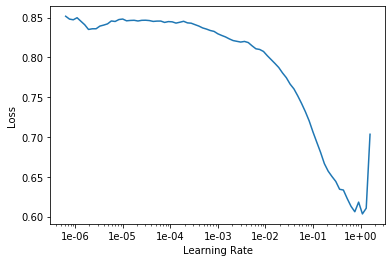

In [ ]:
learn_c.recorder.plot()
logwriter.append_row([getloggerdt(),'plotting classifier learning rate'])

In [ ]:
lr=1e-2
logwriter.append_row([getloggerdt(),'classifier learning rate='+str(lr)])
learn_c.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.118499,0.114143,0.957018,00:49


In [ ]:
learn_c.save(trans+'_first')
logwriter.append_row([getloggerdt(),'classifier top layer training saved as '+trans+"_first"])

In [ ]:
learn_c.load(trans+'_first');

In [ ]:
logwriter.append_row([getloggerdt(),'Unfreezing top 3 layers of classifier and training'])
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.141831,0.144570,0.950736,00:56


In [ ]:
learn_c.save(trans+'_2nd')
logwriter.append_row([getloggerdt(),'classifier top 3 layers training saved as '+trans+"_2nd"])

In [ ]:
learn_c.load(trans+'_2nd')

In [ ]:
logwriter.append_row([getloggerdt(),'Unfreezing top 4 layers of classifier and training'])
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.107132,0.161605,0.950570,01:24


In [ ]:
learn_c.save(trans+'_3rd')
logwriter.append_row([getloggerdt(),'classifier top 3 layers training saved as '+trans+"_3rd"])

In [ ]:
learn_c.load(trans+'_3rd')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (24195 items)
x: TextList
xxbos xxmaj if there is no resurrection of the dead , then not even xxmaj christ has been raised .,xxbos xxmaj you are judging by appearances . xxmaj if anyone is confident that they belong to xxmaj christ , they should consider again that we belong to xxmaj christ just as much as they do .,xxbos xxmaj for we believe that xxmaj jesus died and rose again , and so we believe that xxmaj god will bring with xxmaj jesus those who have fallen asleep in him .,xxbos xxmaj you who boast in the law , do you dishonor xxmaj god by breaking the law ?,xxbos xxmaj then he appeared to xxmaj james , then to all the apostles ,
y: CategoryList
Paul,Paul,Paul,Paul,Paul
Path: /content/drive/My Drive/AI & Tech Research/PaulAI/DigitialJesus/Courtney_s Work - Summer2019/BibleGateway;

Valid: LabelList (6049 items)
x: TextList
xxbos that is , that you and i may be xxunk encouraged by each other ’s faith .,xxbos xxmaj therefore xxmaj

change ep to the number of epochs you wish to run (100 is the default)<br>
This will train the entire classifier. It will search for the most accurate model and then save that when execute the save in the next cell

In [ ]:
#ep=100
ep=10
logwriter.append_row([getloggerdt(),'training entire model for'+str(ep)+' epochs'])
learn_c.unfreeze()
learn_c.fit_one_cycle(ep, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7),callbacks=[SaveModelCallback(learn_c, every='improvement',monitor='accuracy', name='best_class_'+trans)])

epoch,train_loss,valid_loss,accuracy,time
0,0.709287,0.643612,0.700595,00:34
1,0.328633,0.210170,0.963483,00:31
2,0.102644,0.095461,0.970258,00:34
3,0.073645,0.079510,0.973067,00:34
4,0.053408,0.077108,0.972736,00:34
5,0.031336,0.077885,0.974884,00:33
6,0.024560,0.079723,0.974389,00:32
7,0.018090,0.081636,0.975380,00:33
8,0.011516,0.081438,0.976206,00:34
9,0.014480,0.083612,0.976867,00:34


Better model found at epoch 0 with accuracy value: 0.7005948424339294.
Better model found at epoch 1 with accuracy value: 0.9634831547737122.
Better model found at epoch 2 with accuracy value: 0.9702577590942383.
Better model found at epoch 3 with accuracy value: 0.9730667471885681.
Better model found at epoch 5 with accuracy value: 0.9748843312263489.
Better model found at epoch 7 with accuracy value: 0.9753800630569458.
Better model found at epoch 8 with accuracy value: 0.9762061834335327.
Better model found at epoch 9 with accuracy value: 0.976867139339447.


In [ ]:
learn_c.save('clas_'+trans)
logwriter.append_row([getloggerdt(),'best model saved as class_'+trans])

### run predictor

In [ ]:
logwriter.append_row([getloggerdt(),'run predictor'])
learn_c.load('clas_'+trans)

#learn_c.load('clas'+trans)
#learn_c.

RNNLearner(data=TextClasDataBunch;

Train: LabelList (24209 items)
x: TextList
xxbos xxmaj now if xxmaj christ is preached , that xxmaj he has been raised from the dead , how do some among you say that there is no resurrection of the dead ?,xxbos xxmaj you are looking at things as they are outwardly . xxmaj if anyone is confident in himself that he is xxmaj christ ’s , let him consider this again within himself , that just as he is xxmaj christ ’s , so also are we .,xxbos xxmaj for if we believe that xxmaj jesus died and rose again , even so xxmaj god will bring with xxmaj him those who have fallen asleep in xxmaj jesus .,xxbos xxmaj you who boast in the xxmaj law , through your breaking the xxmaj law , do you dishonor xxmaj god ?,xxbos xxmaj after that xxmaj he appeared to more than five hundred brethren at one time , most of whom remain until now , but some have fallen asleep ;
y: CategoryList
Paul,Paul,Paul,Paul,Paul
Path: /content/drive/My Drive/testai/DigitialJesus/Courtney_s Work

### Change *check* to test a particular book

In [ ]:
#set predict check
check="Philemon"
#df_sel_paul=df_copy.loc[df_copy['classifier'] == 'Paul']
try:
  df_check=df_copy.loc[df_copy['Book']==check]
except NameError:
  df_copy=df.copy()
  df_check=df_copy.loc[df_copy['Book']==check]

df_check.head()

,Version_Full_Name,Version_Abbreviation,Book,Chapter,Verse_Number,Verse_Text,classifier
29939,New American Standard Bible,NASB,Philemon,Philemon,1,"Paul, a prisoner of Christ Jesus, and Timothy ...",Paul
29940,New American Standard Bible,NASB,Philemon,Philemon,2,"and to Apphia our sister, and to Archippus our...",Paul
29941,New American Standard Bible,NASB,Philemon,Philemon,3,Grace to you and peace from God our Father and...,Paul
29942,New American Standard Bible,NASB,Philemon,Philemon,4,"I thank my God always, making mention of you i...",Paul
29943,New American Standard Bible,NASB,Philemon,Philemon,5,because I hear of your love and of the faith w...,Paul


In [ ]:
#interp = TextClassificationInterpretation.from_learner(learn_c) 
df_predict=pd.DataFrame(columns=['Book','Chapter','Verse','Cat','Non-paul_likelihood','Paul_likelihood'])
for index, rows in df_check.iterrows():
    pred=learn_c.predict(rows['Verse_Text'])
    #print(pred)
    #print('cat='+str(pred[0])+' likelihood of non-paul='+str(pred[2][0])+" likelihood of paul="+str(pred[2][1]))
    #interp.show_intrinsic_attention(rows['Verse_Text'])
    df_predict=df_predict.append({'Book':rows['Book'],'Chapter':rows['Chapter'],'Verse':rows['Verse_Number'],
                                 'Cat':str(pred[0]),'Non-paul_likelihood':pred[2][0].item(), 'Paul_likelihood':pred[2][1].item()}, ignore_index=True)
logwriter.append_row([getloggerdt(),'ran prediction for '+check])


{'spreadsheetId': '15atohUJtoredXMk8Zw-EegqvStM--huxZlpsIhrFVsA',
 'tableRange': 'nasb_log!A1:B39',
 'updates': {'spreadsheetId': '15atohUJtoredXMk8Zw-EegqvStM--huxZlpsIhrFVsA',
  'updatedCells': 2,
  'updatedColumns': 2,
  'updatedRange': 'nasb_log!A40:B40',
  'updatedRows': 1}}

In [ ]:
df_predict.head()


,Book,Chapter,Verse,Cat,Non-paul_likelihood,Paul_likelihood
0,Philemon,Philemon,1,Paul,0.001846,0.998154
1,Philemon,Philemon,2,Paul,0.000450,0.999550
2,Philemon,Philemon,3,Paul,0.001958,0.998042
3,Philemon,Philemon,4,Paul,0.000149,0.999851
4,Philemon,Philemon,5,Paul,0.039467,0.960533


In [ ]:
mean_res=df_predict.mean(axis=0, numeric_only=True, skipna=True)
mean_res

Non-paul_likelihood    0.014381
Paul_likelihood        0.985619
dtype: float64

In [ ]:
mean_str=mean_res.to_string()
print(mean_str)

logwriter.append_row([getloggerdt(),'prediction results '+mean_str])


Non-paul_likelihood    0.014381
Paul_likelihood        0.985619


{'spreadsheetId': '15atohUJtoredXMk8Zw-EegqvStM--huxZlpsIhrFVsA',
 'tableRange': 'nasb_log!A1:B40',
 'updates': {'spreadsheetId': '15atohUJtoredXMk8Zw-EegqvStM--huxZlpsIhrFVsA',
  'updatedCells': 2,
  'updatedColumns': 2,
  'updatedRange': 'nasb_log!A41:B41',
  'updatedRows': 1}}

In [ ]:
print('Verse categorization')
paul_count=df_predict.groupby('Cat').size()
print(paul_count)
logwriter.append_row([getloggerdt(),'verse categorization= '+paul_count.to_string()])


Verse categorization
Cat
Paul    25
dtype: int64


{'spreadsheetId': '15atohUJtoredXMk8Zw-EegqvStM--huxZlpsIhrFVsA',
 'tableRange': 'nasb_log!A1:B41',
 'updates': {'spreadsheetId': '15atohUJtoredXMk8Zw-EegqvStM--huxZlpsIhrFVsA',
  'updatedCells': 2,
  'updatedColumns': 2,
  'updatedRange': 'nasb_log!A42:B42',
  'updatedRows': 1}}

In [ ]:
#prepare numbers for spreadsheet
type(mean_res)
mean_res_list=mean_res.to_list()
mean_res_list

[0.014381215746107045, 0.9856187772750854]

In [ ]:
#create spreadsheet cells
out_list=[check]+mean_res.to_list()+paul_count.to_list()
out_list

['Philemon', 0.014381215746107045, 0.9856187772750854, 25]

In [ ]:
#post to spreadsheet
cell_list=worksheet.range(1,last_col,5,last_col)
j=0
for cell in cell_list:
    cell.value=out_list[j]
    j=j+1
worksheet.update_cells(cell_list)
last_col+=1
logwriter.append_row([getloggerdt(),'Posted results to spreadsheet'])


IndexError: ignored

### Model Interpretation

In [ ]:
#Run first to create interpreter
interp=TextClassificationInterpretation.from_learner(learn_c)


In [ ]:
#SET VERSE AND CHAPTER
chapter=1
verse=3


In [ ]:
df_check=df_check.astype({'Chapter':'int64'})
check_text_ser=df_check.loc[(df_check['Verse_Number'] ==verse) & (df_check['Chapter']==chapter) ].Verse_Text
check_text=check_text_ser.iloc[0]
print(check_text)


Blessed be the God and Father of our Lord Jesus Christ, who has blessed us with every spiritual blessing in the heavenly places in Christ,


In [ ]:
df_predict.dtypes
df_predict=df_predict.astype({'Chapter':'int64'},{'Verse':'int64'})


In [ ]:
import matplotlib.cm as cm

print(df_predict.loc[(df_predict['Verse']==verse) & (df_predict['Chapter']==chapter)])

interp.show_intrinsic_attention(check_text,cmap=cm.Purples)
interp.intrinsic_attention(check_text)


        Book  Chapter Verse   Cat  Non-paul_likelihood  Paul_likelihood
2  Ephesians        1     3  Paul             0.036072         0.963928


(Text xxbos xxmaj blessed be the xxmaj god and xxmaj father of our xxmaj lord xxmaj jesus xxmaj christ , who has blessed us with every spiritual blessing in the heavenly places in xxmaj christ ,,
 tensor([0.1128, 0.1532, 0.9053, 0.6172, 0.3694, 0.3360, 0.6350, 0.5408, 0.2933,
         0.7356, 0.4185, 0.6342, 0.3372, 0.6291, 0.3630, 0.7760, 0.3762, 0.6530,
         0.1608, 0.2381, 0.3793, 0.7730, 0.6412, 0.3731, 0.3695, 0.5580, 0.7069,
         0.3400, 0.2558, 0.5253, 0.6802, 0.5342, 0.3309, 1.0000, 0.8153],
        device='cuda:0'))